In [50]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [51]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [52]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [53]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_taylor2, load_taylor1a,load_misery, time_split
from common.calc_metrics import model_results

# Setup

## variables

In [54]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [55]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_test', train0_df['FEDFUNDS'], train0_df['ffef_tr'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], test0_df.shape[0], 2 , model_stats_df )

model_stats_df = model_results('ffef_tr2_test', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)
train_df:  (200, 18)
test_df:  (50, 18)


,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-0.9567,-0.9666,22.8365,4.7788
1,ffef_tr_test,-39.0258,-39.8596,54.7667,7.4005
2,ffef_tr2_test,0.4458,0.4430,6.4680,2.5432
3,ffef_tr2_test,-13.4214,-13.7219,19.7326,4.4421
4,Naive_test,0.9206,0.9202,0.9263,0.9624
5,Naive_test,0.8830,0.8805,0.1601,0.4002


# Load Data

# Stats Model - Taylor Index

In [56]:
taylor_df = load_taylor()
taylor_df = taylor_df.query('index < "2007-01-01"')
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)
train_df:  (147, 18)
test_df:  (37, 18)


In [57]:
X_train = train_df[['FEDFUNDS-1']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['FEDFUNDS-1']]
y_test = test_df['FEDFUNDS']

In [58]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
#cat_columns_lst = ['recession_flag','chair_name']
#cat_columns_lst = ['recession_flag']
num_columns_lst = ['FEDFUNDS-1']


#ohe_categories = list()
#for c in cat_columns_lst:
#    ohe_categories.append(list(X_train[c].unique()))
    
#ohe = OneHotEncoder(categories=ohe_categories, drop='first',
#                   sparse_output=False, handle_unknown='ignore')

#transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')



numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
#categorical_transformer = Pipeline( steps=[('transformer',transformer)])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
#        ("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [59]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)


X_train_const = sm.add_constant(X_train_trf)

In [60]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     1239.
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           6.53e-73
Time:                        20:06:32   Log-Likelihood:                -217.34
No. Observations:                 147   AIC:                             438.7
Df Residuals:                     145   BIC:                             444.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4227      0.201      2.104      0.037       0.026       0.820
num__FEDFUNDS-1     0.9407      0.027     35.197      0.000       0.888       0.994
==============================================================================
Omnibus:                       52.015   Durbin-Watson:                   1.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              428.468
Skew:                           0.953   Prob(JB):                     9.11e-94
Kurtosis:                      11.144   Cond. No.                         17.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [62]:
model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [63]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (37, 2)


In [64]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(37, 6)

In [65]:
model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )

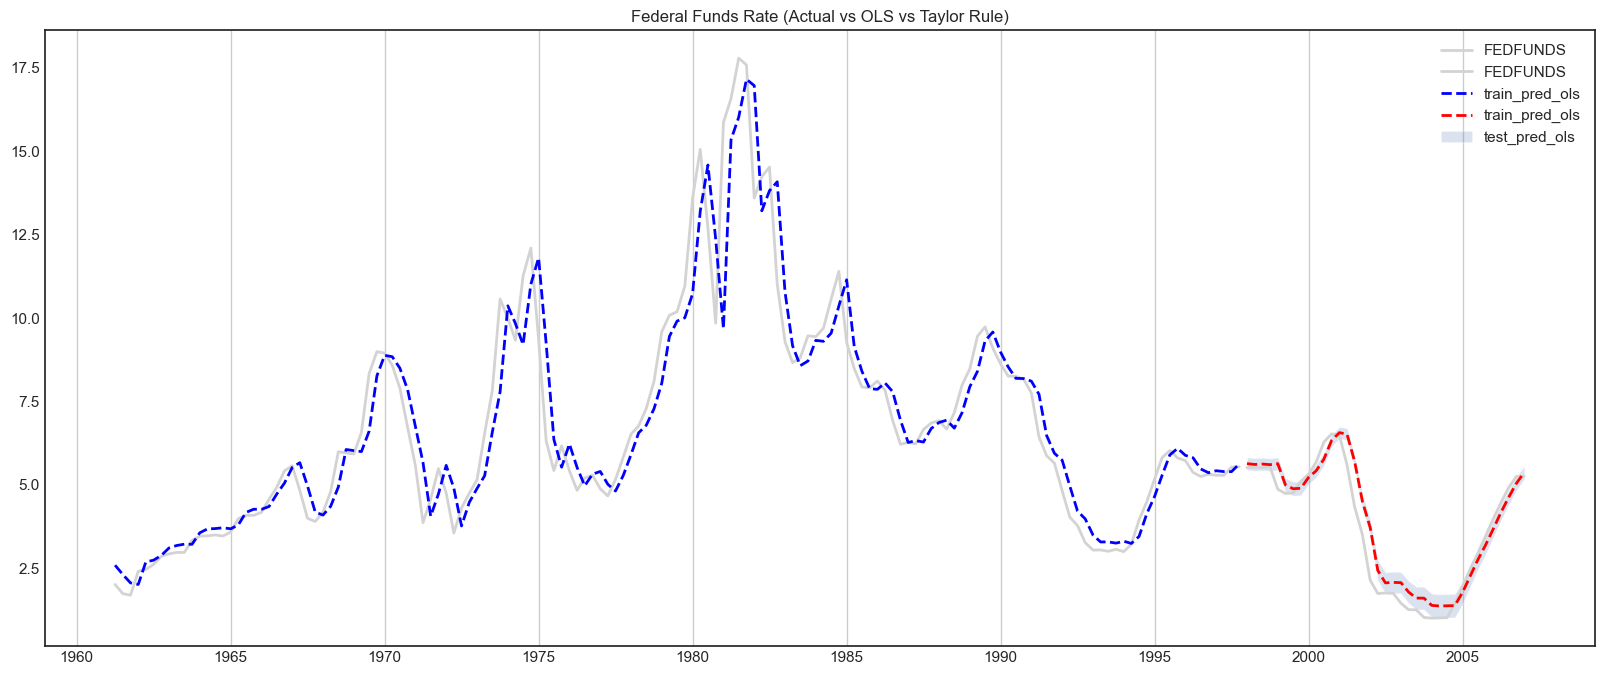

In [66]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# LGBM

In [67]:
ltb_model = ltb.LGBMRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_lgbm = ltb_model.predict(X_train_trf, pred_contrib=False, raw_score=False)

<Axes: >

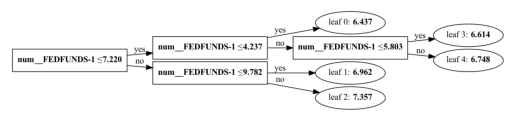

In [68]:
ltb.plot_tree(ltb_model)

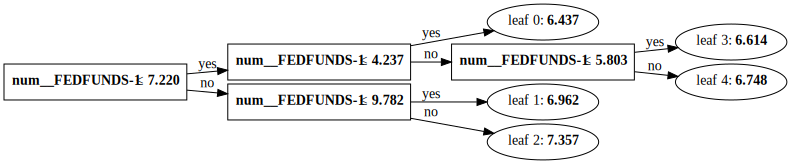

In [69]:
ltb.create_tree_digraph(ltb_model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

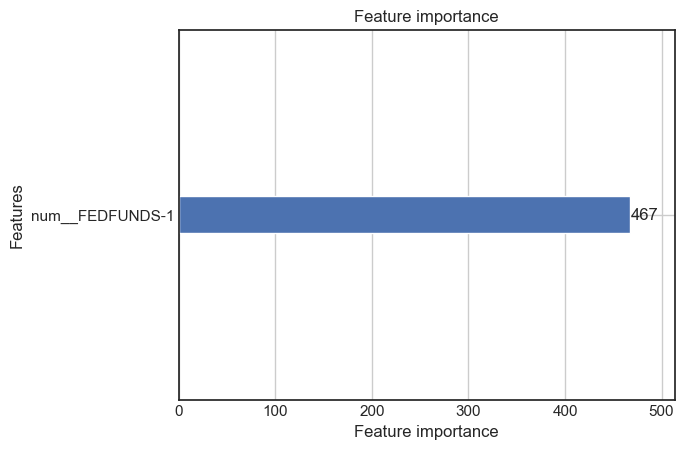

In [70]:
ltb.plot_importance(ltb_model)

In [71]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], X_train.shape[1]  , model_stats_df )

## Test

In [72]:
test_pred_lgbm = ltb_model.predict(X_test_trf, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(37,)

In [73]:
model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

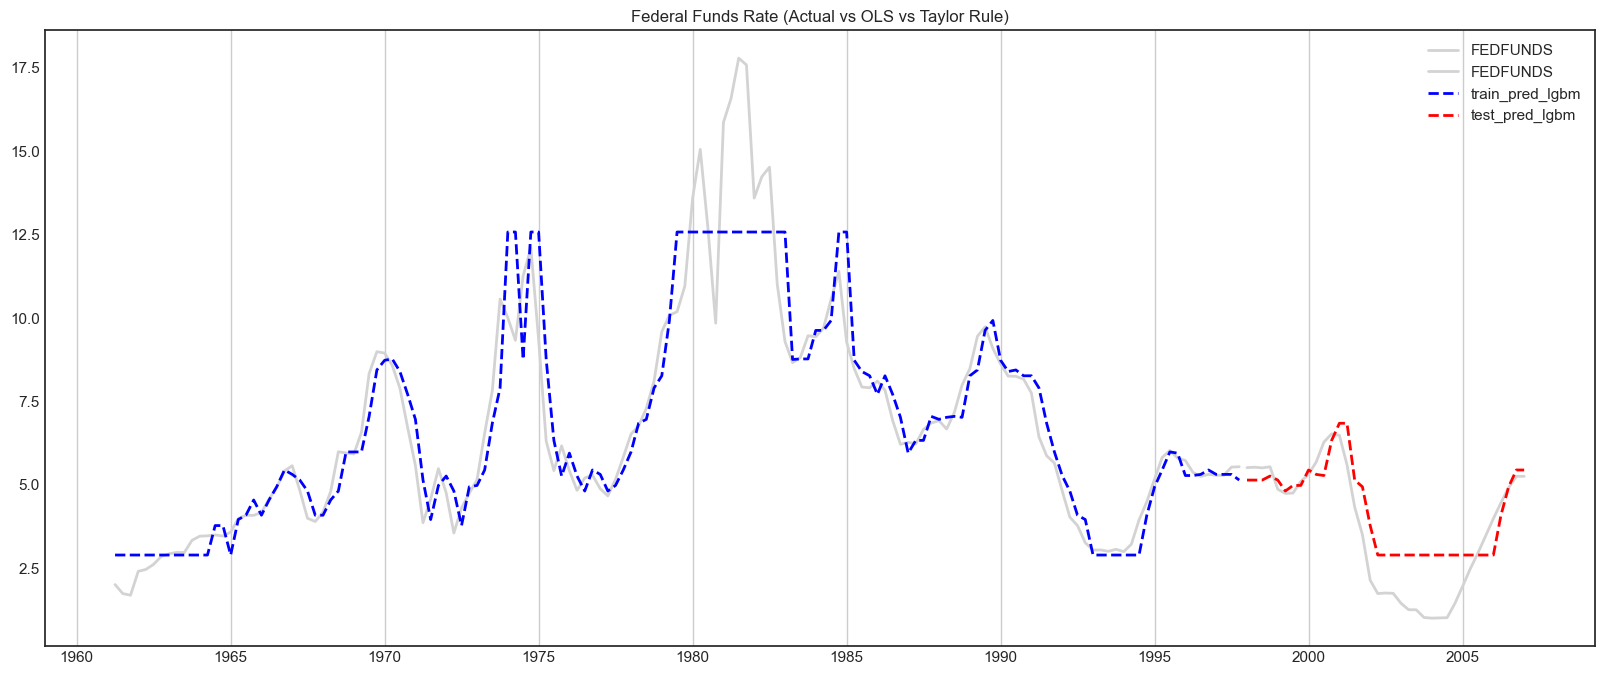

In [74]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# XGB

In [75]:
xgb_model = xgb.XGBRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_xgb = xgb_model.predict(X_train_trf)
xgb_model.score(X_train_trf, y_train)

0.9998413219084828

In [76]:
model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], X_train.shape[1], model_stats_df )

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

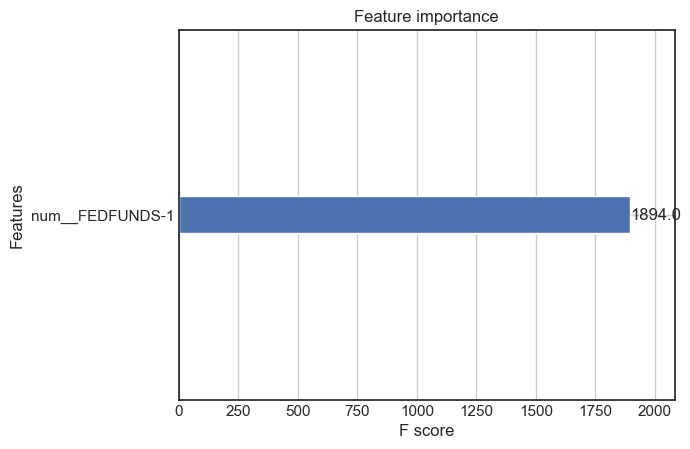

In [77]:
xgb.plot_importance(xgb_model)

In [78]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(xgb_model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

fig.show()

## Test

In [79]:
test_pred_xgb = xgb_model.predict(X_test_trf)
test_pred_xgb.shape

(37,)

In [80]:
model_stats_df = model_results('xgb_test', y_test, test_pred_xgb, X_train.shape[0], X_test.shape[1] , model_stats_df )

# AdaBoostRegressor

In [81]:
ada_model = AdaBoostRegressor().fit(X_train_trf, y_train)
train_pred_ada = ada_model.predict(X_train_trf)

model_stats_df = model_results('ada_test', y_train, train_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

In [82]:
test_pred_ada = ada_model.predict(X_test_trf)
model_stats_df = model_results('ada_test', y_test, test_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

# tsa.SARIMAX

In [100]:
taylor2006_df = load_taylor()
#taylor2006_df = taylor2006_df.query('index < "2007-01-01"')
taylor2006_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)


,FEDFUNDS,UNRATE,TB3MS,GDPC1,GDPPOT,GDPDEF_PC1,Growth_g,Real_Interest_Rate,Output_Gap,gap_inf,gap_gdp,gap_ue,ffef_tr,ffef_tr2,recession_flag,chair_name,chair_index,FEDFUNDS-1
DATE,,,,,,,,,,,,,,,,,,
1961-03-31,2.003333,6.800000,2.350000,3493.703,3385.151548,1.1,4.828759,5.493491,-3.755573,-0.9,3.206694,-1.800000,4.253347,1.750000,False,Martin,8,2.296667
1961-06-30,1.733333,7.000000,2.303333,3553.021,3414.679709,1.1,4.989798,5.682399,-3.407557,-0.9,4.051369,-2.000000,4.675685,1.650000,False,Martin,8,2.003333
1961-09-30,1.683333,6.766667,2.303333,3621.252,3445.236389,1.0,4.923091,5.609036,-2.640213,-1.0,5.108956,-1.766667,5.054478,1.616667,False,Martin,8,1.733333
1961-12-31,2.400000,6.200000,2.460000,3692.289,3476.671046,1.0,4.910719,5.592011,-1.931028,-1.0,6.201851,-1.200000,5.600925,1.900000,False,Martin,8,1.683333
1962-03-31,2.456667,5.633333,2.723333,3758.147,3510.589803,1.3,4.767864,5.431519,-1.116593,-0.7,7.051727,-0.633333,6.475863,2.633333,False,Martin,8,2.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0.770000,3.600000,1.076667,21708.160,20153.810000,7.7,1.728947,0.666278,4.479321,5.7,7.712437,1.400000,16.406219,13.250000,False,Powell,15,0.120000
2022-09-30,2.190000,3.566667,2.663333,21851.134,20245.660000,7.3,1.850930,0.785472,4.164357,5.3,7.929966,1.433333,15.914983,12.666667,False,Powell,15,0.770000
2022-12-31,3.653333,3.600000,4.040000,21989.981,20334.210000,6.4,1.825866,0.717093,4.018788,4.4,8.142785,1.400000,14.671392,11.300000,False,Powell,15,2.190000


In [101]:
train2006_df, test2006_df = time_split(taylor2006_df)

train_df:  (200, 18)
test_df:  (50, 18)


In [103]:
#X_train = train2006_df[['FEDFUNDS-1']]
X_train = train2006_df[['recession_flag']]

#X_train_trf = t_fit.transform(X_train)


y_train = train2006_df['FEDFUNDS']

In [104]:
#model = sm.tsa.SARIMAX(y_train, exog=X_train_trf)
model = sm.tsa.SARIMAX(y_train, trend='c' , exog=X_train)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  200
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -273.077
Date:                Mon, 20 Nov 2023   AIC                            552.155
Time:                        21:17:42   BIC                            562.050
Sample:                    03-31-1961   HQIC                           556.159
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
recession_flag     0.7568      0.210      3.605      0.000       0.345       1.168
ar.L1              0.9864      0.006    153.742      0.000       0.974       0.999
sigma2             0.8823      0.036     24.664      0.000       0.812       0.952
===================================================================================
Ljung-Box (L1) (Q):                   9.86   Jarque-Bera (JB):               914.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [88]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS,mean,mean_se,mean_ci_lower,mean_ci_upper
1961-03-31,2.264268,1.077862,0.151699,4.376838
1961-06-30,1.975073,1.077862,-0.137497,4.087643
1961-09-30,1.708882,1.077862,-0.403688,3.821452
1961-12-31,1.659587,1.077862,-0.452983,3.772157
1962-03-31,2.366144,1.077862,0.253574,4.478714
...,...,...,...,...
1996-09-30,5.169368,1.077862,3.056798,7.281937
1996-12-31,5.231807,1.077862,3.119238,7.344377
1997-03-31,5.205517,1.077862,3.092947,7.318087
1997-06-30,5.202231,1.077862,3.089661,7.314800


## Test

In [89]:
X_test = test2006_df[['FEDFUNDS-1','gap_inf', 'gap_ue', 'Real_Interest_Rate', 'recession_flag']]
X_test_trf = t_fit.transform(X_test)

y_test = train2006_df['FEDFUNDS']

In [90]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [91]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(37, 4)

In [92]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

,lower FEDFUNDS,upper FEDFUNDS
1997-12-31,4.762001,6.184793
1998-03-31,4.706371,6.159071
1998-06-30,4.715922,6.169880
1998-09-30,4.695567,6.149578
1998-12-31,4.728303,6.182316


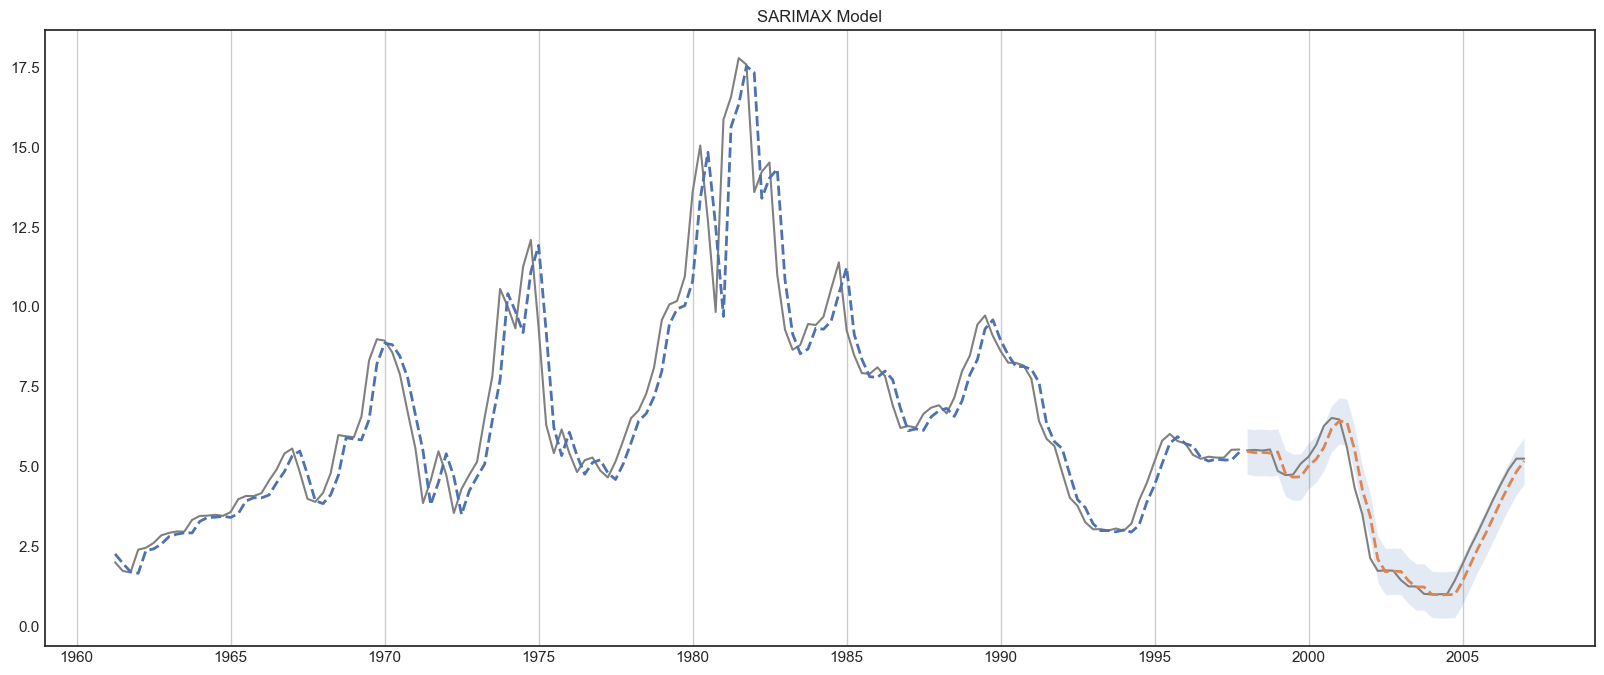

In [93]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train2006_df.index, train2006_df['FEDFUNDS'], 'gray')
ax.plot(test2006_df.index, test2006_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS'], predict_ci['upper FEDFUNDS'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [94]:
print('SARIMAX RMSE(Train):' , statsmodels.tools.eval_measures.rmse(train2006_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX RMSE(Test):' , statsmodels.tools.eval_measures.rmse(test2006_df['FEDFUNDS'], test_pred_SARIM['mean']))

SARIMAX RMSE(Train): 1.0781818071056493
SARIMAX RMSE(Test): 0.47770521497791735


In [95]:
print('SARIMAX R-Squard(Train):' , r2_score(train2006_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX R-Squard(Test):' , r2_score(test2006_df['FEDFUNDS'], test_pred_SARIM['mean']))

SARIMAX R-Squard(Train): 0.8918709290304354
SARIMAX R-Squard(Test): 0.9344090732019338


In [96]:
X_train.shape[1]

1

In [97]:
model_stats_df = model_results('SARIMAX_train',train2006_df['FEDFUNDS'], train_pred_SARIM['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )
model_stats_df = model_results('SARIMAX_test', test2006_df['FEDFUNDS'], test_pred_SARIM['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-0.9567,-0.9666,22.8365,4.7788
1,ffef_tr_test,-39.0258,-39.8596,54.7667,7.4005
2,ffef_tr2_test,0.4458,0.4430,6.4680,2.5432
3,ffef_tr2_test,-13.4214,-13.7219,19.7326,4.4421
4,Naive_test,0.9206,0.9202,0.9263,0.9624
5,Naive_test,0.8830,0.8805,0.1601,0.4002
6,ols_train,0.8952,0.8952,1.1265,1.0614
7,ols_test,0.9221,0.9221,0.2709,0.5205
8,lgbm_train,0.8605,0.8605,1.5001,1.2248
9,lgbm_test,0.6940,0.6940,1.0647,1.0319
